In [466]:
# Assignment: Open Data Policies comments scrape

import re
import util
import bs4
import queue
import json
import sys
import csv
import urllib
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.book import *
import distance
import jellyfish
import sys
#nltk.download()
from nltk.corpus import stopwords
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from nltk import tokenize
#from textblob import TextBlob
#from textblob import TextBlob
#textblob.download()

In [47]:
stop = set(stopwords.words('english'))
stop.update(['-', '&', "'s", '.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '.', 'the', ',', 'and', 'of', ';', 'for', 'that', 'on', 'to', 'a', 'or', 'is', 'in', '’', '"', '”', "" ])

In [48]:
starting_urls_list = ["https://mymadison.io/documents/city-of-buffalo-open-data-policy", 
                      "https://mymadison.io/documents/durham-open-data-policy",
                      "https://mymadison.io/documents/city-of-tyler-data-policy",
                      "https://mymadison.io/documents/city-of-glendale-draft-open-data-resolution",
                      "https://mymadison.io/documents/metro-nashville-government-open-data-policy",
                      "https://mymadison.io/documents/city-of-syracuse-open-data-policy",
                      "https://mymadison.io/documents/napervilleopendatapolicy",
                      "https://mymadison.io/documents/bart-open-data-policy",
                      "https://mymadison.io/documents/san-francisco-open-data-legislation-2014"]

In [49]:
starting_url = "https://mymadison.io/documents/city-of-buffalo-open-data-policy?comment_page=1"

## Auxillary functions

In [50]:
def simple_crawl(starting_url):
    '''
    Scrapes the full webpage from a starting url.

    Inputs:
        starting_url: string
    Returns:
        a soup object
    '''    
    page = urllib.request.urlopen(starting_url)
    if page is not None:
        soup = bs4.BeautifulSoup(page, "html")
        return soup

In [51]:
def comment_id(comment):
    comment_id = comment.get('id')
    return comment_id

In [52]:
def name(comment):
    name_date = comment.find("div", class_="media-body media-middle")
    name = name_date.find("span")
    name_final = name.string.strip()
    return name_final, name_date

In [53]:
def datetime(comment):
    name_date = name(comment)[1]
    time = name_date.find("time")
    datetime_final = time.get("datetime")[:-6]
    datetime_final_1 = datetime_final.replace("T", " ")
    return datetime_final_1

In [54]:
def likes_count(comment):
    name_date = name(comment)[1]
    likes = name_date.find("span", class_="action-count")
    return likes.string.strip()

In [55]:
def quoted_comment(comment):
    comments = comment.find("div", class_="comment-content")
    quoted_comment = comments.find("blockquote")
    if quoted_comment is not None:
        quoted_comment_final = quoted_comment.text.strip()
        return quoted_comment_final, comments
    else:
        return None, comments

In [56]:
def actual_comment(comment):
    comments = comment.find("div", class_="comment-content")
    actual_comments = comments.find_all("p", recursive=False)
    
    complete_str_aux = ''
    complete_str_str = ''
    
    for child in actual_comments:
        complete_str_aux += str(child)
        complete_str_str += str(child.text)
    return complete_str_aux, complete_str_str

In [57]:
def reply_ids(comment):
    
    replies = comment.find_all("div", class_="comment")
    if replies is not None:
        reply_id_list = []
        for reply in replies:
            reply_id=reply.get('id')
            reply_id_list.append(reply_id)

        return reply_id_list
    else:
        return []

In [58]:
def find_total_num_pages(starting_url):
    soup = simple_crawl(starting_url)
    next_page = soup.find_all("ul", class_="pagination")
    
    for page in next_page:
        pages = page.find_all("a")
        total_num_pages = pages[-2].get("href")
        return int(total_num_pages[-1])

In [59]:
def calling_functions(commentators, comments_dictionary, comment_number):
    
    for comment in commentators:
        
        comment_id_f = comment_id(comment)
        name_f =  name(comment)
        timedate_f = datetime(comment)
        likes_count_f = likes_count(comment)
        quoted_comment_f = quoted_comment(comment)
        actual_comment_f, actual_comment_str =  actual_comment(comment)
        reply_ids_f = reply_ids(comment)


        comments_dictionary[comment_number] = [comment_id_f,name_f[0], timedate_f, 
                                      likes_count_f, quoted_comment_f[0],
                                       actual_comment_str, actual_comment_f, reply_ids_f]
        comment_number += 1
    
    return comments_dictionary, comment_number

## Function to scrape a particular open data policy

In [60]:
def scrape_all_pages(starting_url):
    '''
    This functions scrapes the required data from all the webpages for a PARTICULAR starting url of a Madison webpage.
    '''
    comments_dictionary = {}
    num_pages_to_crawl = find_total_num_pages(starting_url)
    
    if num_pages_to_crawl is None:
        num_pages_to_crawl = 1
        
    loop_number = 0
    comment_number = 1

    while loop_number < num_pages_to_crawl:
    
        soup = simple_crawl(starting_url)
        commentators = soup.findAll("li", class_="comment floating-card")
        
        comments_dictionary, comment_number = calling_functions(commentators, comments_dictionary, comment_number)
        
        next_page = soup.find_all("ul", class_="pagination")
        for page in next_page:
            pages = page.find_all("a")
            starting_url = pages[-1].get("href")
        
        loop_number += 1
        
    return comments_dictionary

In [61]:
comments_dictionary = scrape_all_pages(starting_url)

/Users/summerfellow/anaconda/envs/py35/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/summerfellow/anaconda/envs/py35/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


In [62]:
def convert_dict_pandas(comments_dictionary):
    
    df = pd.DataFrame(comments_dictionary)
    df = df.transpose()
    df.columns = ['comment_id', 'author', 'datetime', 'num_likes', 'quoted_text', 'comment_text', 'comment_text_aux', 'reply_ids']
    
    # converting str datetime into datetime pandas format
    df['datetime'] = pd.to_datetime(df['datetime'])
    return df

In [63]:
convert_dict_pandas(comments_dictionary).head()

,comment_id,author,datetime,num_likes,quoted_text,comment_text,comment_text_aux,reply_ids
1,E4-XFnl1uKc,Aaron Lee,2017-01-25 04:32:19,2,None,I am in support of the proposed policy to furt...,<p>I am in support of the proposed policy to f...,[]
2,E4-XFnjG3Ac,Aaron Lee,2017-01-25 04:25:20,0,public participation by providing regular oppo...,I would be interested to see this more finely ...,<p>I would be interested to see this more fine...,[]
3,E4-XFnQhy2g,Aaron Krolikowski,2017-01-24 22:56:17,3,None,"I strongly support the proposed policy, with a...","<p>I strongly support the proposed policy, wit...",[]
4,E4-XFnNQNY8,Aaron Krolikowski,2017-01-24 22:46:57,0,"Publish high quality, updated data with docume...",Can the portal include an option for community...,<p>Can the portal include an option for commun...,[]
5,E4-XFnJHPCA,Aaron Krolikowski,2017-01-24 22:45:58,0,limitations on the disclosure of public inform...,It may be a helpful option to include a reposi...,<p>It may be a helpful option to include a rep...,[]


In [64]:
temp = convert_dict_pandas(comments_dictionary)

In [65]:
# temp['quoted_text'].dropna().map(lambda y: y.replace('<p>','').replace('</p>','')).apply(lambda x: pd.Series(x).value_counts()).sum()
temp['quoted_text'].dropna().apply(lambda x: pd.Series(x.lower().split()).value_counts()).sum().sort_values(ascending=False).head()

the     27.0
and     22.0
data    20.0
of      16.0
for     10.0
dtype: float64

## scrape all the open data policy comments

In [66]:
all_cities_names = ['Buffalo', 'Durham', 'Tyler', 'Glendale', 'Nashville', 'Syracuse', 'Naperville', 'Bart', 'San Francisco']

def go_all_madison_websites(starting_urls_list):
    '''
    This function scrapes the comments from all the Madison related webistes for cities that have
    launched open data policies and converts them into pandas dataframe objects.
    
    Returns:
        DataFrame object for each city's open data policy.
    '''
    i = 0
    all_madison_websites_dfs = []
    all_cities_dataframe = pd.DataFrame()
    for starting_url in starting_urls_list:
        #print(starting_url)
        comments_dictionary = scrape_all_pages(starting_url)
        get_dict_to_pandas = convert_dict_pandas(comments_dictionary)
        #relative_url = starting_url.split('/')[-1]
        get_dict_to_pandas['city_name'] = all_cities_names[i]
        all_madison_websites_dfs.append((all_cities_names[i], get_dict_to_pandas))
        all_cities_dataframe = all_cities_dataframe.append(get_dict_to_pandas)
        i += 1
        
    return all_madison_websites_dfs, all_cities_dataframe

In [67]:
all_madison_dfs, all_cities_dataframe = go_all_madison_websites(starting_urls_list)

/Users/summerfellow/anaconda/envs/py35/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/summerfellow/anaconda/envs/py35/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


In [68]:
all_cities_dataframe.head()

,comment_id,author,datetime,num_likes,quoted_text,comment_text,comment_text_aux,reply_ids,city_name
1,E4-XFnl1uKc,Aaron Lee,2017-01-25 04:32:19,2,None,I am in support of the proposed policy to furt...,<p>I am in support of the proposed policy to f...,[],Buffalo
2,E4-XFnjG3Ac,Aaron Lee,2017-01-25 04:25:20,0,public participation by providing regular oppo...,I would be interested to see this more finely ...,<p>I would be interested to see this more fine...,[],Buffalo
3,E4-XFnQhy2g,Aaron Krolikowski,2017-01-24 22:56:17,3,None,"I strongly support the proposed policy, with a...","<p>I strongly support the proposed policy, wit...",[],Buffalo
4,E4-XFnNQNY8,Aaron Krolikowski,2017-01-24 22:46:57,0,"Publish high quality, updated data with docume...",Can the portal include an option for community...,<p>Can the portal include an option for commun...,[],Buffalo
5,E4-XFnJHPCA,Aaron Krolikowski,2017-01-24 22:45:58,0,limitations on the disclosure of public inform...,It may be a helpful option to include a reposi...,<p>It may be a helpful option to include a rep...,[],Buffalo


In [24]:
author_names_dict = {}
for author_name in all_cities_dataframe['author'].unique():
    author_names_dict[author_name] = None

In [26]:
for name, city in all_madison_dfs:
    print(name)

Buffalo
Durham
Tyler
Glendale
Nashville
Syracuse
Naperville
Bart
San Francisco


# Analysis

## 1) finding out most common words in quoted texts (policy sections)

### -most common words in quoted texts

In [29]:
def common_words_quoted_texts(type_of_text, city_name, city_dictionary, common_words_limit):
    string_quoted_text = city_dictionary[type_of_text].str.cat(sep=' ').lower()
    words = nltk.tokenize.word_tokenize(string_quoted_text)
    good_words = [i for i in words if i not in stop] # stop words
    fdist = FreqDist(good_words)
    common_quoted_text_20 = fdist.most_common(common_words_limit)
    df = pd.DataFrame(data=common_quoted_text_20, columns=['word', 'count'])
    return df, fdist.plot(common_words_limit, title=city_name)

### for each city

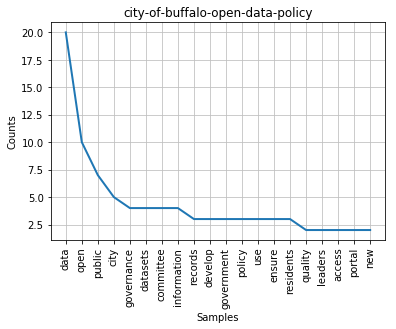

(           word  count
0          data     20
1          open     10
2        public      7
3          city      5
4    governance      4
5      datasets      4
6     committee      4
7   information      4
8       records      3
9       develop      3
10   government      3
11       policy      3
12          use      3
13       ensure      3
14    residents      3
15      quality      2
16      leaders      2
17       access      2
18       portal      2
19          new      2, None)


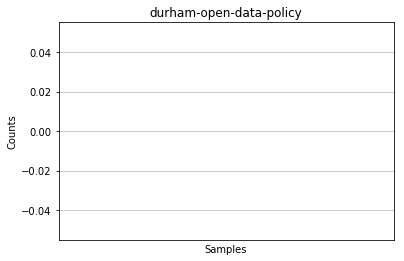

(Empty DataFrame
Columns: [word, count]
Index: [], None)


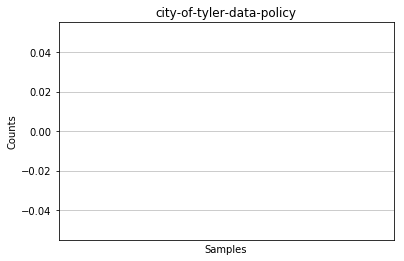

(Empty DataFrame
Columns: [word, count]
Index: [], None)


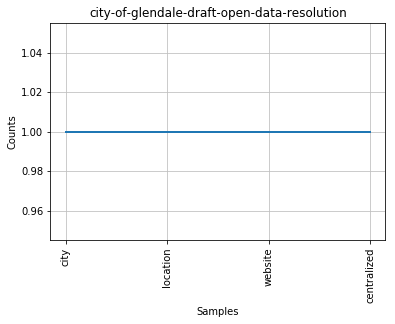

(          word  count
0         city      1
1     location      1
2      website      1
3  centralized      1, None)


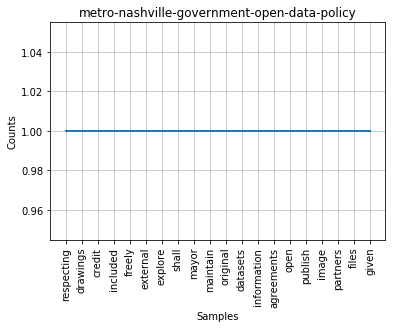

(           word  count
0    respecting      1
1      drawings      1
2        credit      1
3      included      1
4        freely      1
5      external      1
6       explore      1
7         shall      1
8         mayor      1
9      maintain      1
10     original      1
11     datasets      1
12  information      1
13   agreements      1
14         open      1
15      publish      1
16        image      1
17     partners      1
18        files      1
19        given      1, None)


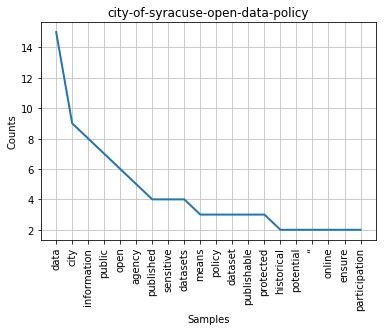

(             word  count
0            data     15
1            city      9
2     information      8
3          public      7
4            open      6
5          agency      5
6       published      4
7       sensitive      4
8        datasets      4
9           means      3
10         policy      3
11        dataset      3
12    publishable      3
13      protected      3
14     historical      2
15      potential      2
16              “      2
17         online      2
18         ensure      2
19  participation      2, None)


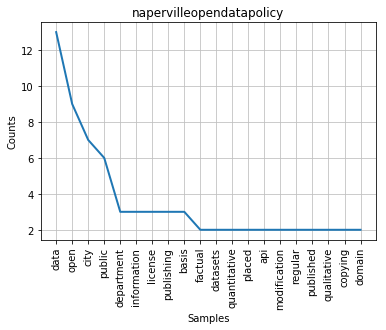

(            word  count
0           data     13
1           open      9
2           city      7
3         public      6
4     department      3
5    information      3
6        license      3
7     publishing      3
8          basis      3
9        factual      2
10      datasets      2
11  quantitative      2
12        placed      2
13           api      2
14  modification      2
15       regular      2
16     published      2
17   qualitative      2
18       copying      2
19        domain      2, None)


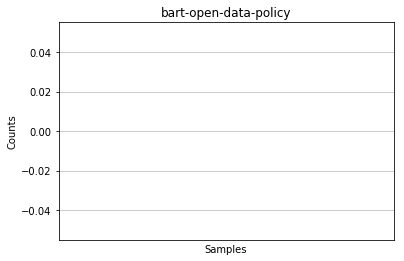

(Empty DataFrame
Columns: [word, count]
Index: [], None)


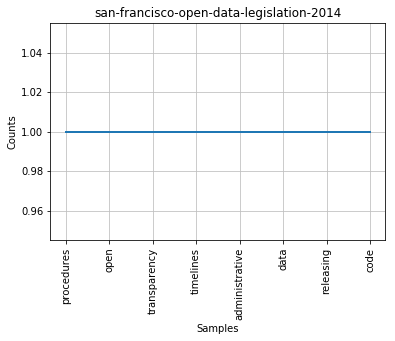

(             word  count
0      procedures      1
1            open      1
2    transparency      1
3       timelines      1
4  administrative      1
5            data      1
6       releasing      1
7            code      1, None)


In [30]:
for name, dictionary in all_madison_dfs:
    #print(name)
    print(common_words_quoted_texts('quoted_text', name, dictionary, 20))
    

### for all the cities combined


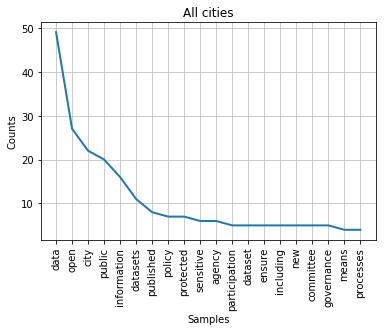

(             word  count
 0            data     49
 1            open     27
 2            city     22
 3          public     20
 4     information     16
 5        datasets     11
 6       published      8
 7          policy      7
 8       protected      7
 9       sensitive      6
 10         agency      6
 11  participation      5
 12        dataset      5
 13         ensure      5
 14      including      5
 15            new      5
 16      committee      5
 17     governance      5
 18          means      4
 19      processes      4, None)

In [31]:
common_words_quoted_texts("quoted_text", "All cities", all_cities_dataframe, 20)

## 2) finding out most common words in actual comments

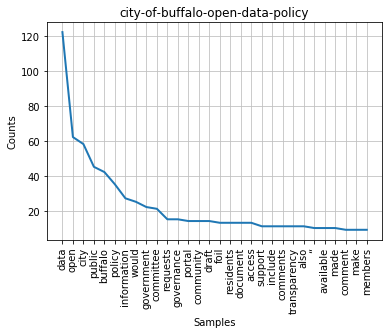

(            word  count
0           data    122
1           open     62
2           city     58
3         public     45
4        buffalo     42
5         policy     35
6    information     27
7          would     25
8     government     22
9      committee     21
10      requests     15
11    governance     15
12        portal     14
13     community     14
14         draft     14
15          foil     13
16     residents     13
17      document     13
18        access     13
19       support     11
20       include     11
21      comments     11
22  transparency     11
23          also     11
24             “     10
25     available     10
26          made     10
27       comment      9
28          make      9
29       members      9, None)


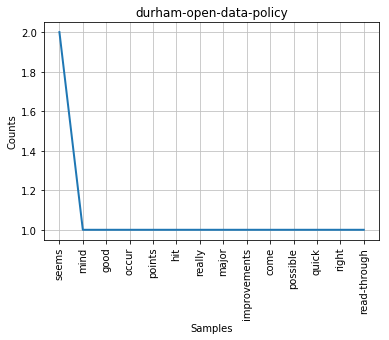

(            word  count
0          seems      2
1           mind      1
2           good      1
3          occur      1
4         points      1
5            hit      1
6         really      1
7          major      1
8   improvements      1
9           come      1
10      possible      1
11         quick      1
12         right      1
13  read-through      1, None)


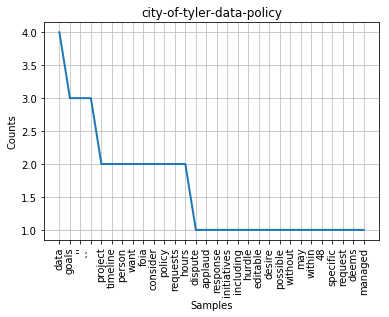

(           word  count
0          data      4
1         goals      3
2            ''      3
3            ``      3
4       project      2
5      timeline      2
6        person      2
7          want      2
8          foia      2
9      consider      2
10       policy      2
11     requests      2
12        hours      2
13      dispute      1
14      applaud      1
15     response      1
16  initiatives      1
17    including      1
18       hurdle      1
19     editable      1
20       desire      1
21     possible      1
22      without      1
23          may      1
24       within      1
25           48      1
26     specific      1
27      request      1
28        deems      1
29      managed      1, None)


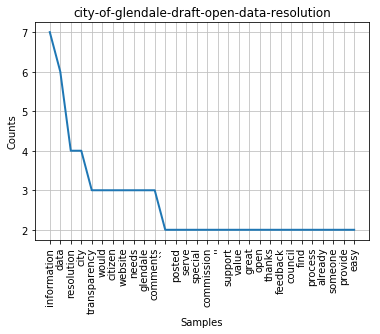

(            word  count
0    information      7
1           data      6
2     resolution      4
3           city      4
4   transparency      3
5          would      3
6        citizen      3
7        website      3
8          needs      3
9       glendale      3
10      comments      3
11            ``      2
12        posted      2
13         serve      2
14       special      2
15    commission      2
16            ''      2
17       support      2
18         value      2
19         great      2
20          open      2
21        thanks      2
22      feedback      2
23       council      2
24          find      2
25       process      2
26       already      2
27       someone      2
28       provide      2
29          easy      2, None)


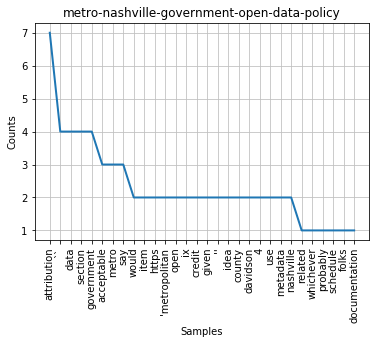

(             word  count
0     attribution      7
1              ``      4
2            data      4
3         section      4
4      government      4
5      acceptable      3
6           metro      3
7             say      3
8           would      2
9            item      2
10          https      2
11  'metropolitan      2
12           open      2
13             ix      2
14         credit      2
15          given      2
16             ''      2
17           idea      2
18         county      2
19       davidson      2
20              4      2
21            use      2
22       metadata      2
23      nashville      2
24        related      1
25      whichever      1
26       probably      1
27       schedule      1
28          folks      1
29  documentation      1, None)


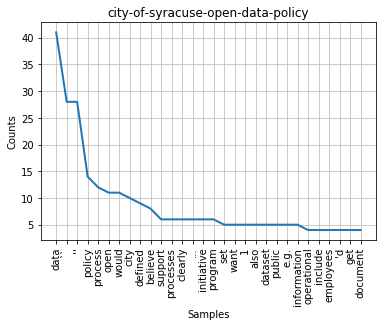

(           word  count
0          data     41
1            ``     28
2            ''     28
3        policy     14
4       process     12
5          open     11
6         would     11
7          city     10
8       defined      9
9       believe      8
10      support      6
11    processes      6
12      clearly      6
13          ...      6
14   initiative      6
15      program      6
16          set      5
17         want      5
18            1      5
19         also      5
20      dataset      5
21       public      5
22         e.g.      5
23  information      5
24  operational      4
25      include      4
26    employees      4
27           'd      4
28          get      4
29     document      4, None)


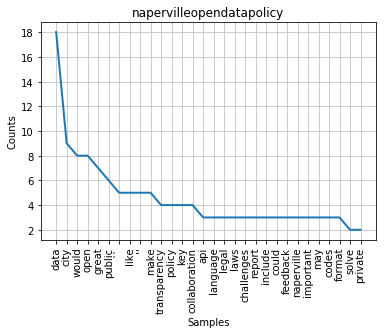

(             word  count
0            data     18
1            city      9
2           would      8
3            open      8
4           great      7
5          public      6
6              ``      5
7            like      5
8              ''      5
9            make      5
10   transparency      4
11         policy      4
12            key      4
13  collaboration      4
14            api      3
15       language      3
16          legal      3
17           laws      3
18     challenges      3
19         report      3
20        include      3
21          could      3
22       feedback      3
23     naperville      3
24      important      3
25            may      3
26          codes      3
27         format      3
28          solve      2
29        private      2, None)


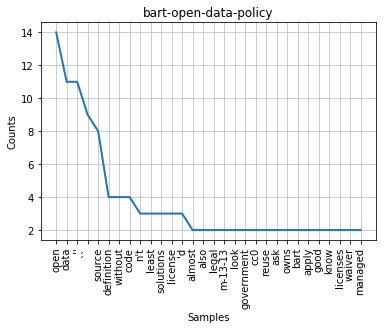

(          word  count
0         open     14
1         data     11
2           ''     11
3           ``      9
4       source      8
5   definition      4
6      without      4
7         code      4
8          n't      3
9        least      3
10   solutions      3
11     license      3
12          'd      3
13      almost      2
14        also      2
15       legal      2
16     m-13-13      2
17        look      2
18  government      2
19         cc0      2
20       reuse      2
21         ask      2
22        owns      2
23        bart      2
24       apply      2
25        good      2
26        know      2
27    licenses      2
28      waiver      2
29     managed      2, None)


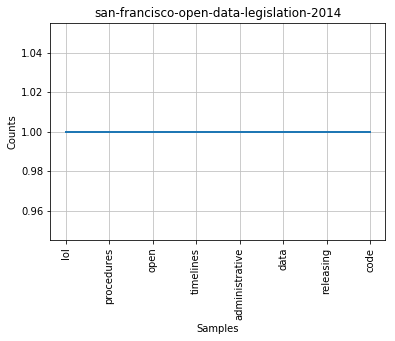

(             word  count
0             lol      1
1      procedures      1
2            open      1
3       timelines      1
4  administrative      1
5            data      1
6       releasing      1
7            code      1, None)


In [32]:
for name, dictionary in all_madison_dfs:
    #print(name)
    print(common_words_quoted_texts('comment_text', name, dictionary, 30))

### for all the cities combined


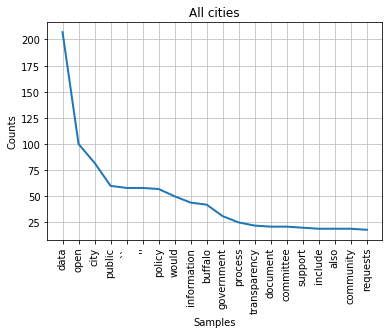

(            word  count
 0           data    207
 1           open    100
 2           city     82
 3         public     60
 4             ``     58
 5             ''     58
 6         policy     57
 7          would     50
 8    information     44
 9        buffalo     42
 10    government     31
 11       process     25
 12  transparency     22
 13      document     21
 14     committee     21
 15       support     20
 16       include     19
 17          also     19
 18     community     19
 19      requests     18, None)

In [33]:
common_words_quoted_texts("comment_text", "All cities", all_cities_dataframe, 20)

## 2) finding out most common quoted policy sections (n-grams)

In [27]:
string_quoted_text_list = temp['quoted_text'].dropna().tolist()

In [464]:
from nltk.util import ngrams
from collections import Counter

def extract_phrases(string_quoted, length):
    phrase_counter = Counter()
    for sentence in string_quoted:
        non_speaker = re.compile('[A-Za-z]+: (.*)')
        for sent in nltk.sent_tokenize(sentence):
            strip_speaker = non_speaker.match(sent)
            if strip_speaker is not None:
                sent = strip_speaker.group(1)
            words = nltk.word_tokenize(sent)
            for phrase in ngrams(words, length):
                phrase_counter[phrase] += 1
    
        #extract_phrases(sentence, phrase_counter, 3)
    most_common_phrases = phrase_counter.most_common(10)
    
    most_common_phrases_new = []
    
    for k,v in most_common_phrases:
        #print ('{0: <5}'.format(v), k)
        p = ' '.join(k)
        #print(k)
        most_common_phrases_new.append((p, v))
    
    return most_common_phrases_new

In [29]:
def top_policy_sections_commented(type_of_data, option, length):
    
    total_sentence_count_list = []
    
    if type(type_of_data) == list: #if its a list of dictionaries of all the cities
        
        for name, dictionary in type_of_data:
            if option == "most_common_policy": # if the option is to find out comments of popular sections of each city
                list_of_lists_sentences = list_of_lists_of_sentences(name, dictionary, length)[0]
                
                if len(list_of_lists_sentences) != 0: # don't print results for cities with no comments. (???)
                    sentiment_analysis_list = sentiment_analysis(list_of_lists_sentences, name, dictionary)
                    sentimental_analysis_graphs = sentimental_analysis_charts(sentiment_analysis_list, "both")   
                    print (sentimental_analysis_graphs)
                    
            else:
                string_quoted_text_list = dictionary['comment_text'].dropna().tolist()
                sentiment_analysis_list = sentiment_analysis(string_quoted_text_list, name, dictionary)
            
                total_sentence_count_list.append(sentiment_analysis_list[-3])
                total_sentence_count_list.append(sentiment_analysis_list[-4])
                #print(name)
                sentimental_analysis_graphs = sentimental_analysis_charts(sentiment_analysis_list, "both")   
                print (sentimental_analysis_graphs)
        
            if len(total_sentence_count_list) != 0:
                if total_sentence_count_list[-1] == "san-francisco-open-data-legislation-2014":
                    sentimental_analysis_graphs_tot_sent = sentimental_analysis_charts(total_sentence_count_list, "tot_sent")
                    print (sentimental_analysis_graphs_tot_sent)
                
    else: # it its one big dictionary containing data for all the cities
        name = "All Cities"
        
        if option == "most_common_policy": # if the option is to find out comments of popular sections
            list_of_lists_sentences, most_common_phrases  = list_of_lists_of_sentences(name, type_of_data, length)
            sentiment_analysis_list = sentiment_analysis(list_of_lists_sentences, name, all_cities_dataframe)
            sentimental_analysis_graphs = sentimental_analysis_charts(sentiment_analysis_list, "both")
            return (sentimental_analysis_graphs, sentiment_analysis_list[-2], sentiment_analysis_list[-1], most_common_phrases)
        
        else: # if the option is to find out all the comments of all policy sections
            string_quoted_text_list = all_cities_dataframe['comment_text'].dropna().tolist()
            sentiment_analysis_list = sentiment_analysis(string_quoted_text_list, name, all_cities_dataframe)
            sentimental_analysis_graphs = sentimental_analysis_charts(sentiment_analysis_list, "both")
            
            return (sentimental_analysis_graphs, sentiment_analysis_list[-2], sentiment_analysis_list[-1])

In [30]:
def list_of_lists_of_sentences(name, dictionary, length):
    
    string_quoted_text_list = dictionary['quoted_text'].dropna().tolist()
    most_common_phrases = extract_phrases(string_quoted_text_list, length)
    #for k,v in most_common_phrases:
    #    print(k,v)   
    list_of_lists_sentences, city_name = most_common_phrases_to_list(name, dictionary, most_common_phrases)
    return list_of_lists_sentences, most_common_phrases

In [31]:
def most_common_phrases_to_list(city_name, city_dictionary, most_common_phrases):
    
    list_of_lists_sentences = []
    for string_phrase, len_string_phrase in most_common_phrases:
        actual_comment_filter = city_dictionary[city_dictionary['quoted_text'].astype(str).str.contains(string_phrase)]
        comment_list_sentiment = actual_comment_filter['comment_text'].tolist()
        list_of_lists_sentences.append(comment_list_sentiment)

    return (list_of_lists_sentences, city_name)

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk import tokenize

def sentiment_scores(sentence_list, city_dictionary, total_sentence_count, neg_count, neg_polarity, neu_count, neu_polarity, pos_count, pos_polarity):
    sid = SentimentIntensityAnalyzer()
    negative_comments = []
    positive_comments = []
    for sentence in sentence_list:
        
        ss = sid.polarity_scores(sentence)
        if ss['neg'] >= 0.3 and ss['neu'] <0.7 and ss['pos'] <0.3:
            neg_count += 1
            neg_polarity += ss['neg']
            negative_comments.append(sentence)
            print("negative sentence:", sentence)
        elif ss['neu'] >= 0.7 and ss['neg'] <0.3 and ss['pos'] <0.3:
            neu_count += 1
            neu_polarity += ss['neu']
        elif ss['pos'] >= 0.3 and ss['neu'] <0.7 and ss['neg'] <0.3:
            pos_count += 1
            pos_polarity += ss['pos']
            positive_comments.append(sentence)
            print("positive sentence:", sentence)

        total_sentence_count += 1
    return total_sentence_count, neg_count, neg_polarity, neu_count, neu_polarity, pos_count, pos_polarity, negative_comments, positive_comments

/Users/summerfellow/anaconda/envs/py35/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [33]:
def sentiment_analysis(list_of_lists_of_sentences, city_name, dictionary):

    neg_count = 0
    neu_count = 0
    pos_count = 0
    neg_polarity = 0
    neu_polarity = 0
    pos_polarity = 0
    
    total_sentence_count = 0
    
    if type(list_of_lists_of_sentences[0]) == list:
        for sentence_list in list_of_lists_of_sentences:
            total_sentence_count, neg_count, neg_polarity, neu_count, neu_polarity, pos_count, pos_polarity, neg_sentences, pos_sentences = sentiment_scores(sentence_list, dictionary, total_sentence_count, neg_count, neg_polarity, neu_count, neu_polarity, pos_count, pos_polarity)
            
    else:
        total_sentence_count, neg_count, neg_polarity, neu_count, neu_polarity, pos_count, pos_polarity, neg_sentences, pos_sentences = sentiment_scores(list_of_lists_of_sentences, dictionary, total_sentence_count, neg_count, neg_polarity, neu_count, neu_polarity, pos_count, pos_polarity)
        
    print()
    print("total_comments:", total_sentence_count, "----", "city name:", city_name)
    
    #total_sentence_count_list.append(total_sentence_count)
    
    if total_sentence_count == 0:
        total_sentence_count = 1
    
    avg_neg_polarity = neg_polarity/total_sentence_count
    avg_neu_polarity = neu_polarity/total_sentence_count
    avg_pos_polarity = pos_polarity/total_sentence_count
                
    return ["neg count", neg_count, "neu_count", neu_count, "pos_count", pos_count, "avg_neg_polarity", avg_neg_polarity, "avg_neu_polarity", avg_neu_polarity, "avg_pos_polarity", avg_pos_polarity, city_name, total_sentence_count, neg_sentences, pos_sentences]

In [34]:
def sentimental_analysis_charts(list_, option):
    
    if option == "both":
        
    
        #chart 1: for the count of comments
        fig = plt.figure()
        x_objects = [i for i in list_[:6] if type(i) == str]
        y_pos = np.arange(len(x_objects))
        y_objects = [i for i in list_[:6] if type(i) == int]

        plt.bar(y_pos, y_objects, align='center', alpha=0.7, color="red")
        plt.xticks(y_pos, x_objects)
        plt.ylabel('Count of comments')
        plt.title('Sentiment Analysis Count -' + " " + list_[-4], weight="bold")
        plt.tight_layout()
        plt.show()
        fig.savefig('sentiment-count-' + list_[-4] + '.png', dpi = 200)
        #fig.close()

        #chart 2 for the average polarity of comments
        fig = plt.figure()
        x_objects = [i for i in list_[6:-4] if type(i) == str]
        y_pos = np.arange(len(x_objects))
        y_objects = [i for i in list_[6:-4] if type(i) == float]
        plt.bar(y_pos, y_objects, align='center', alpha=0.7)
        plt.xticks(y_pos, x_objects)
        plt.ylim(0, 1)
        plt.ylabel('Average polarity of comments')
        plt.title('Sentiment Analysis Averages' + " " + list_[-4], weight="bold")
        plt.tight_layout()
        plt.show()
        fig.savefig('sentiment-polarity-' + list_[-4] + '.png', dpi = 200)
    
    elif option == "tot_sent":
    
        # Chart 3 for the count of total sentences
        #print(list_)
        x_objects = ['Buffalo', 'Durham', 'Tyler', 'Glendale', 'Nashville', 'Syracuse', 'Naperville', 'Bart', 
                    'San Francisco']
        #x_objects = [i for i in list_ if type(i) == str]
        y_pos = np.arange(len(x_objects))
        y_objects = [i for i in list_ if type(i) == int]
        
        fig = plt.figure()
        plt.bar(y_pos, y_objects, align='center', alpha=0.7, color="green")
        plt.xticks(y_pos, x_objects, rotation=70)
        #plt.margins(0.2)
        plt.ylabel('Count of comments')
        plt.title('City-wise all comments count', weight="bold")
        plt.tight_layout()
        plt.show()
        fig.savefig('fig1.png', dpi = 200)
        #fig.close()

## sentiment analysis for each city for comments of most commonly quoted policy sections

positive sentence: That would be super helpful :)

total_comments: 14 ---- city name: Buffalo


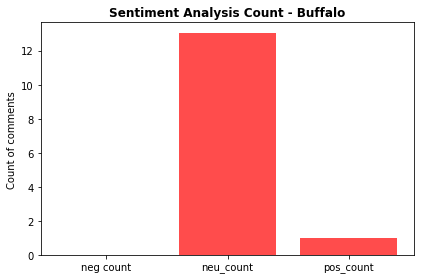

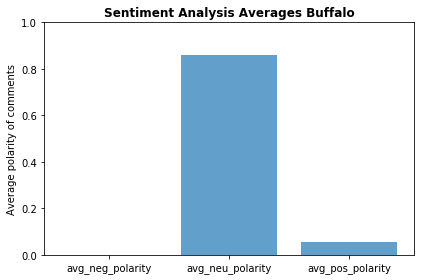

None

total_comments: 4 ---- city name: Glendale


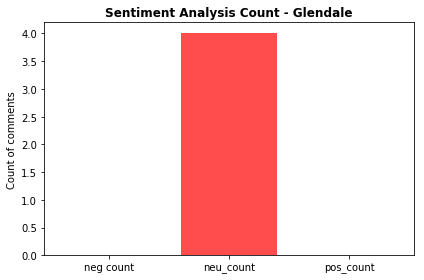

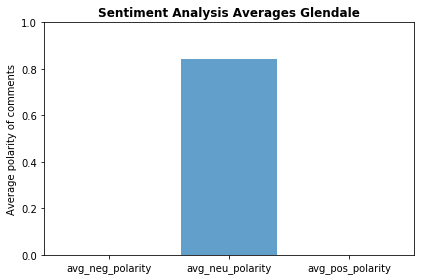

None
positive sentence: Awesome!
positive sentence: Awesome!
positive sentence: Awesome!

total_comments: 4 ---- city name: Nashville


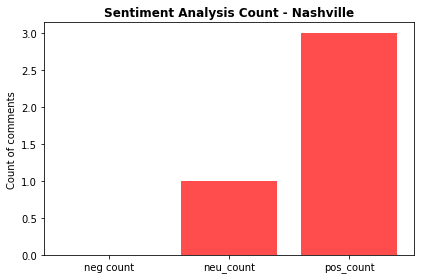

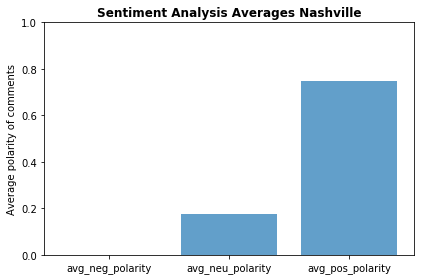

None

total_comments: 6 ---- city name: Syracuse


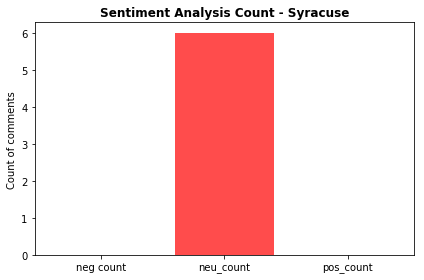

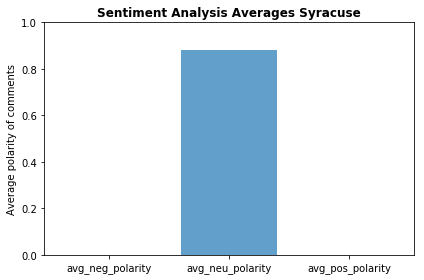

None

total_comments: 12 ---- city name: Naperville


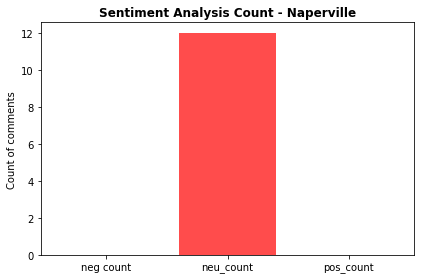

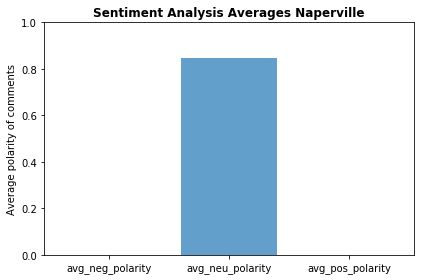

None

total_comments: 5 ---- city name: San Francisco


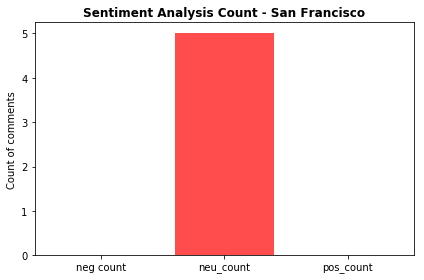

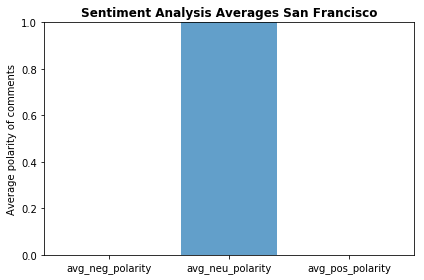

None


In [35]:
sentimental_analysis_graphs_1 = top_policy_sections_commented(all_madison_dfs, "most_common_policy", 3)

## sentiment analysis for each city for all comments

positive sentence: equitable access to opportunity (open data can help move us closer to this goal)
positive sentence: Promote open data that informs increases in government efficiency, improvements in the quality of life of its citizens, and more equal opportunities for all residents.
negative sentence: risks to the public
positive sentence: this is amazing. Very important.
positive sentence: protected information
positive sentence: A central location is a good idea, IMHO
positive sentence: That would be super helpful :)

total_comments: 66 ---- city name: Buffalo


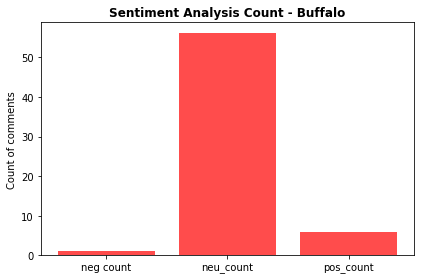

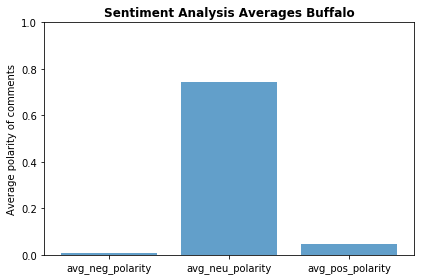

None

total_comments: 1 ---- city name: Durham


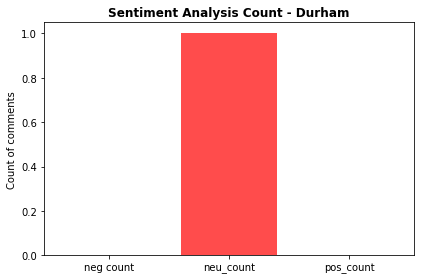

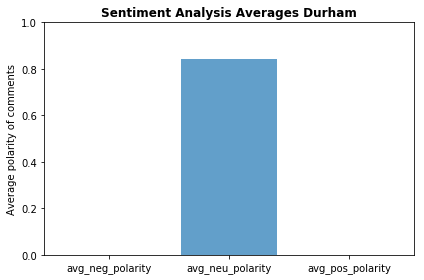

None

total_comments: 4 ---- city name: Tyler


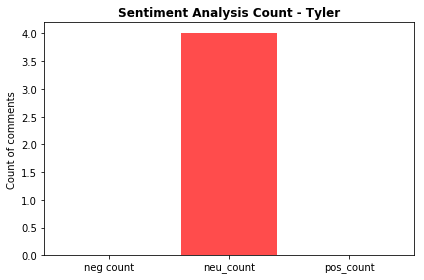

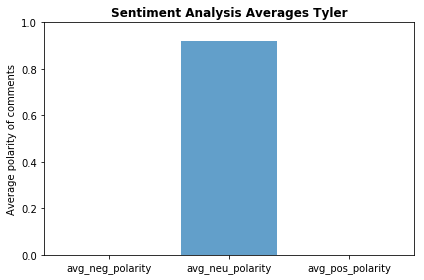

None
positive sentence: This resource would be of great value to the Human Resources Commission.  The demographic information would help serve as a guide to commission activities.  Kudos for the concept.

total_comments: 10 ---- city name: Glendale


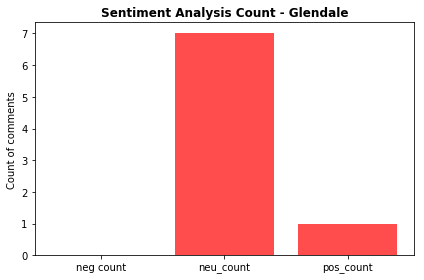

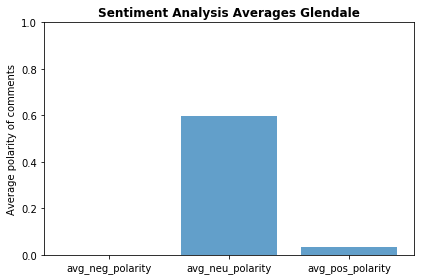

None
positive sentence: Awesome!
positive sentence: Cheers for this!

total_comments: 6 ---- city name: Nashville


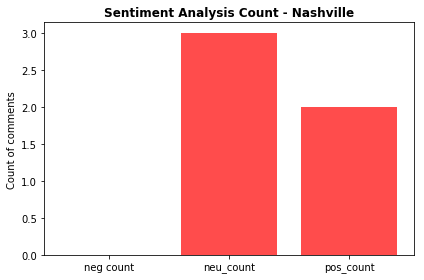

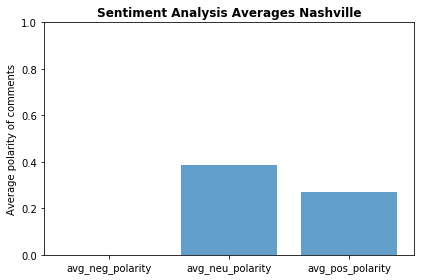

None
positive sentence: "Permanence" is a strong guarantee a priori, and could imply quadratically growing storage costs (e.g., if you save a bunch of snapshots). Also, publishing "with permanence" is a weird phrase. :)
positive sentence: redundant - protect & sensitive are ultimately the same
positive sentence: YES
positive sentence: This is terrific. A solid policy that will serve the city well and provide important guidance to city departments for releasing open data.
positive sentence: This would be a great opportunity for Syracuse to organize some community resources in a way that can increase civic engagement and generate transparency and accountability.

total_comments: 50 ---- city name: Syracuse


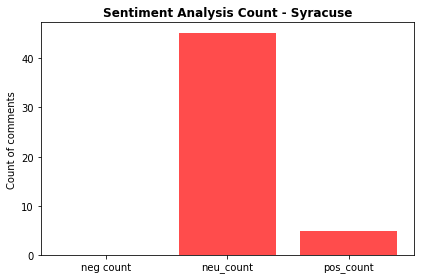

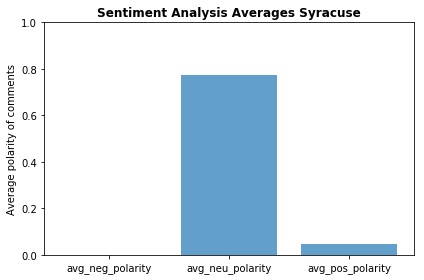

None
positive sentence: Datasets should also be analyzed and improved to be customer friendly.
positive sentence: Metadata helps users understand a dataset
positive sentence: Great idea. I would like to see how data is classified into private and public.

total_comments: 24 ---- city name: Naperville


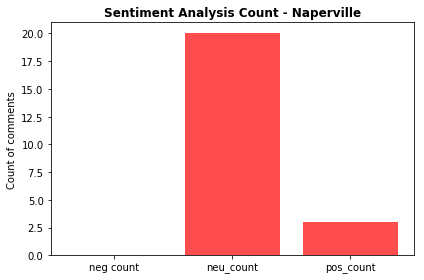

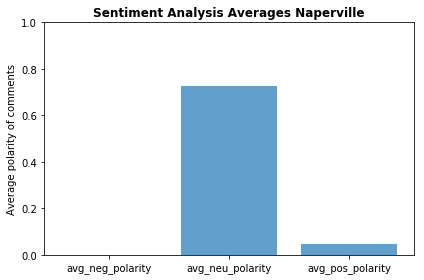

None

total_comments: 1 ---- city name: Bart


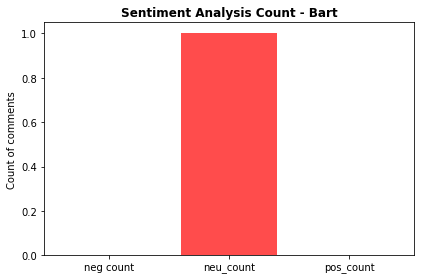

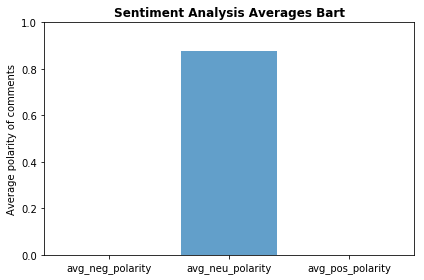

None
positive sentence: LOL

total_comments: 2 ---- city name: San Francisco


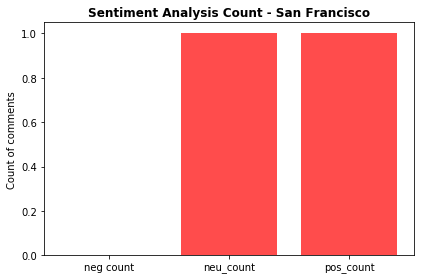

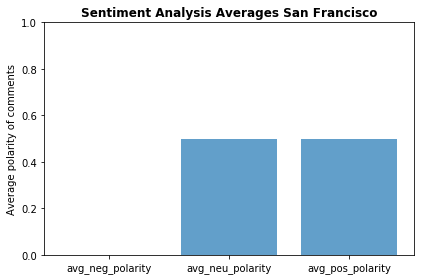

None


In [36]:
sentimental_analysis_graphs_2 = top_policy_sections_commented(all_madison_dfs, "all_common_comments", 3)

## sentiment analysis for all the cities (aggregate) for most commonly quoted policy sections

positive sentence: Datasets should also be analyzed and improved to be customer friendly.

total_comments: 23 ---- city name: All Cities


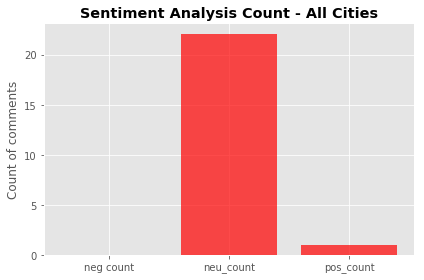

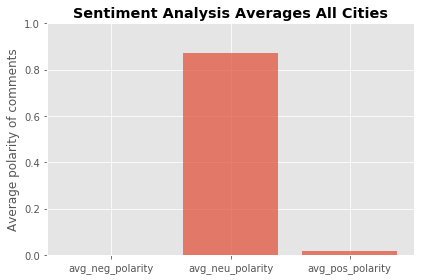

In [482]:
sentimental_analysis_graphs_3 = top_policy_sections_commented(all_cities_dataframe, "most_common_policy", 4)

#### Analyzing the most popular policy sections

In [483]:
popular_sections = sentimental_analysis_graphs_3[3]
filtered_pop_sections = pd.DataFrame()

for phrase, count in popular_sections:
    filtered_pop_sections = filtered_pop_sections.append(all_cities_dataframe[all_cities_dataframe['quoted_text'].astype(str).str.contains(phrase)])

filtered_pop_sections = filtered_pop_sections.reset_index()

In [484]:
popular_sections

[('Open Data Governance Committee', 5),
 ('protected and sensitive information', 4),
 ('the city ’ s', 3),
 ('Develop and implement a', 3),
 ('and implement a process', 3),
 ('and sensitive information ;', 3),
 ('implement a process for', 3),
 ('the Open Data Governance', 3),
 ('disclosure of public information', 2),
 ('available for bulk download', 2)]

In [489]:
filtered_pop_sections = filtered_pop_sections.drop_duplicates("comment_text")

In [490]:
full_quoted_text_pop_sections = ['periodically update the data based on internal and external needs; serve on the Open Data Governance Committee; upon request, meet with the Open Data Governance Committee to discuss any matter pertaining to implementation of this Order; and assist in the preparation of the annual open data compliance report.',
                    'periodically update the data based on internal and external needs; serve on the Open Data Governance Committee; upon request, meet with the Open Data Governance Committee to discuss any matter pertaining to implementation of this Order; and assist in the preparation of the annual open data compliance report.',
                    'periodically update the data based on internal and external needs; serve on the Open Data Governance Committee; upon request, meet with the Open Data Governance Committee to discuss any matter pertaining to implementation of this Order; and assist in the preparation of the annual open data compliance report.',
                    "In order to increase and improve use of the City's open data, the Open Data Governance Committee will actively encourage City department, board and commission, City Council and public participation through providing regular opportunities for feedback and collaboration.",
                    'Minimize limitations on the disclosure of public information while appropriately safeguarding protected and sensitive information;',
                    'Establish processes for publishing datasets to the central open data location, including processes for ensuring that datasets are high quality, up-to-date, are in use-appropriate formats, and exclude protected and sensitive information;',
                    'Minimize limitations on the disclosure of public information while appropriately safeguarding protected and sensitive information;',
                    'Establish processes for publishing datasets to the open data portal, including processes for ensuring that datasets are high-quality, up-to-date, are in use-appropriate formats, and exclude protected and sensitive information;',
                    "Develop and implement a process for prioritizing the release of datasets to the Open Data Portal which takes into account new and existing signals of interest from the public (such as the frequency of FOIL requests), the City's programmatic priorities, existing opportunities for data use in the public interest, and cost;",
                    "Develop and implement a process for prioritizing the release of datasets to the Open Data Portal which takes into account new and existing signals of interest from the public (such as the frequency of FOIL requests), the City's programmatic priorities, existing opportunities for data use in the public interest, and cost;",
                                 "Develop and implement a process for determining the relative level of risk and public benefit associated with potentially sensitive, non-protected information so as to make a determination about whether and how to publish it;",
                    "Minimize limitations on the disclosure of public information while appropriately safeguarding protected and sensitive information;",
                                 "Ensure that published datasets are available for bulk download;",
                                 "Ensure that published datasets are available for bulk download;"]
                    #'Develop and implement a process for guarding against the publishing of potentially sensitive, protected, privileged and/or confidential information;',
                    #'Develop and implement a process for guarding against the publishing of potentially sensitive, protected, privileged and/or confidential information;',
                    #'Develop and implement a process for guarding against the publishing of potentially sensitive, protected, privileged and/or confidential information;']

In [491]:
# based off of old session

filtered_pop_sections['full_quoted_text'] = full_quoted_text_pop_sections

/Users/summerfellow/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [492]:
filtered_pop_sections.head()

,index,comment_id,author,Position,Company_name,Category_work,datetime,num_likes,quoted_text,comment_text,comment_text_aux,reply_ids,city_name,full_quoted_text
0,6,E4-XFnFvMJc,Aaron Krolikowski,Researcher,Freelance,Academia,2017-01-24 22:41:07,1,Open Data Governance Committee,Minutes from any and all meetings of this comm...,<p>Minutes from any and all meetings of this c...,[],Buffalo,periodically update the data based on internal...
1,16,E4-XFk2Ek3s,Curtis Robbins,Unknown,Unknown,Unknown,2017-01-24 18:09:48,0,Open Data Governance Committee,How will this committee be formed? Will it be...,<p>How will this committee be formed? Will it...,[],Buffalo,periodically update the data based on internal...
2,60,E4-XFdoQYDI,Chris Slocum,Unknown,Unknown,Unknown,2017-01-17 01:58:17,1,periodically update the data based on internal...,Would this liaison be the contact person if a ...,<p>Would this liaison be the contact person if...,[E4-XFgdO3sI],Buffalo,periodically update the data based on internal...
3,10,E4-XFccKW8s,Seamus Kraft,Civic Technologist,OpenGov Foundation,Not-for-profit,2016-10-12 12:28:12,0,b. In order to increase and improve use of the...,Excellent! And you're off to a smashing start...,<p>Excellent! And you're off to a smashing st...,[],Naperville,In order to increase and improve use of the Ci...
4,27,E4-XFi-BKtg,Peter Johnson,Researcher,University of Waterloo,Private/Academia,2017-01-24 04:11:48,1,appropriately safeguarding protected and sensi...,Could trim this to just focus on the safeguard...,<p>Could trim this to just focus on the safegu...,[E4-XFmYEcUE],Buffalo,Minimize limitations on the disclosure of publ...


In [496]:
'''
for row in filtered_pop_sections['full_quoted_text'].unique():
    print('\033[1m' + "full quoted text: ")
    print('\033[0m' + row)
    print()
'''

'\nfor row in filtered_pop_sections[\'full_quoted_text\'].unique():\n    print(\'\x1b\' + "full quoted text: ")\n    print(\'\x1b\' + row)\n    print()\n'

In [497]:
for index, row in filtered_pop_sections.iterrows():
    print('\033[1m' + "City:", row['city_name'])
    print('\033[0m' + "Full quoted text:", row['full_quoted_text'])
    print('\033[1m' + "Comment text:", row['comment_text'])
    print()

City: Buffalo
Full quoted text: periodically update the data based on internal and external needs; serve on the Open Data Governance Committee; upon request, meet with the Open Data Governance Committee to discuss any matter pertaining to implementation of this Order; and assist in the preparation of the annual open data compliance report.
Comment text: Minutes from any and all meetings of this committee should be made available in machine-readable formats in an easily-accessible location (including within the open data system)

City: Buffalo
Full quoted text: periodically update the data based on internal and external needs; serve on the Open Data Governance Committee; upon request, meet with the Open Data Governance Committee to discuss any matter pertaining to implementation of this Order; and assist in the preparation of the annual open data compliance report.
Comment text: How will this committee be formed?  Will it be comprised of community stakeholders or only government employe

In [519]:
main_policies = ['Open Data Governance Committee', "Opportunities for Citizen Feedback", 'Privacy and Security', 'Useful, quality and timely data', "Prioritizing the release of open data", "Bulk Download"]
count_pop_policies = [3, 1, 5, 2, 2, 2]

In [521]:
count_pop_policies

[3, 1, 5, 2, 2, 2]

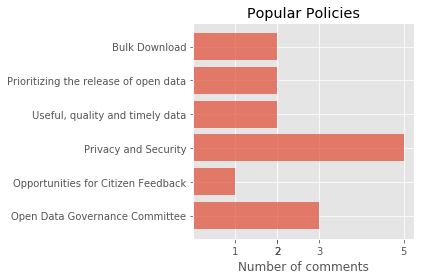

In [552]:
fig = plt.figure()
x_objects = main_policies
y_pos = np.arange(len(x_objects))
y_objects = count_pop_policies

plt.barh(y_pos, y_objects, align='center', alpha=0.7)
plt.xticks(y_objects)
plt.yticks(y_pos, x_objects)
plt.xlabel('Number of comments')
plt.title('Popular Policies')
plt.tight_layout()
plt.show()
fig.savefig('popular-policies.png', dpi = 200)

#### analysis of most commented on policy quotes (need to highlight to Arlington that it is important that these sections are covered in their open data policy and/or adequately addressed)
- periodic update of data
- ensuring that data is of high quality and formatted to common standards
- citizen engagement/feedback to improve the City's open data
- privacy concerns and safeguarding sensitive/confidential data

### sentiment analysis for all the cities (aggregate) for all comments

positive sentence: equitable access to opportunity (open data can help move us closer to this goal)
positive sentence: Promote open data that informs increases in government efficiency, improvements in the quality of life of its citizens, and more equal opportunities for all residents.
negative sentence: risks to the public
positive sentence: this is amazing. Very important.
positive sentence: protected information
positive sentence: A central location is a good idea, IMHO
positive sentence: That would be super helpful :)
positive sentence: This resource would be of great value to the Human Resources Commission.  The demographic information would help serve as a guide to commission activities.  Kudos for the concept.
positive sentence: Awesome!
positive sentence: Cheers for this!
positive sentence: "Permanence" is a strong guarantee a priori, and could imply quadratically growing storage costs (e.g., if you save a bunch of snapshots). Also, publishing "with permanence" is a weird phras

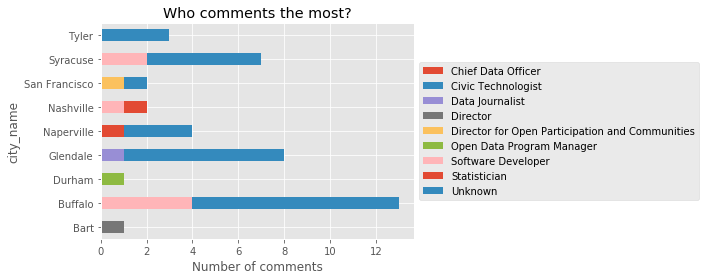

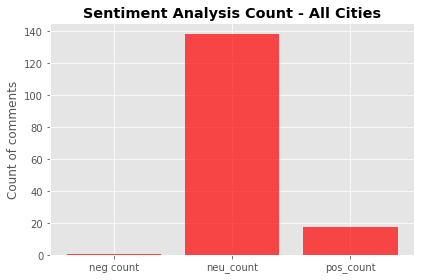

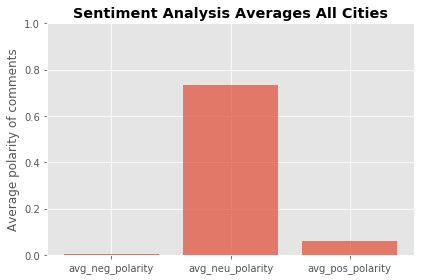

In [576]:
sentimental_analysis_graphs_4 = top_policy_sections_commented(all_cities_dataframe, "all_common_comments", 3)

#### Analyzing positive and negative comments: which policy sections got which -- and why?

#### 1) Positive comments

In [222]:
# positive comments
pos_comments = sentimental_analysis_graphs_4[2]

In [223]:
pos_comments_dict = all_cities_dataframe[all_cities_dataframe['comment_text'].isin(pos_comments)].reset_index()

In [224]:
full_quoted_text = ['Provide open data that increases government efficiency, improves the quality of life of its citizens, and ensures opportunity for all residents.',
                    'Provide open data that increases government efficiency, improves the quality of life of its citizens, and ensures opportunity for all residents.',
                   'This policy will apply to any City department, office, administrative unit, commission, board, advisory committee or other division/department of the City government including the records of third-party agency contractors that create or acquire information, records, or data on behalf of a City division/department.',
                   '"Publishable City data" means data which is not protected or sensitive and which has been prepared for release on the open data web portal.',
                   'Maintain an open data portal that provides a central location for published City data',
                   'Provide for a future means of digitizing archived material that was in existence prior to the development of the Open Data Program;',
                   'None',
                    'Within 90 days of the effective date of this order, pursuant to the training provided to the Departmental Data Coordinator by ITS and the Office of the Mayor, and using a template provided for this purpose, begin to create or update a Departmental Data Catalog of all available Datasets.',
                   'The terms "Data" and "Structured Data" shall not include information in a narrative form, information provided to a Department by other governmental entities; nor image files, such as designs, drawings, photos or scanned copies of original documents; provided, however, that the term "Data" shall include statistical or factual information about image files and geographic information system (GIS) data.',
                   'Publish high quality, updated data with documentation (metadata) and permanence to encourage maximum use',
                   '“Sensitive information” means any data which, if published by the city online, could raise privacy, confidentiality or security concerns or have the potential to jeopardize public health, safety or welfare to an extent that is greater than the potential public benefit of publishing that data.',
                   'Each published dataset should be associated with contact information for the appropriate manager of that dataset as well as with a file layout or data dictionary that provides information about field labels and values.',
                   'None',
                   'None',
                   'Establish processes for publishing datasets to the open data portal, including processes for ensuring that datasets are high-quality, up-to-date, are in use-appropriate formats, and exclude protected and sensitive information.',
                   'Metadata - Data about data. Additional information provided along with a dataset containing additional information about the dataset',
                   'None',
                   'enhanced government transparency and accountability']

In [225]:
pos_comments_dict['full_quoted_text'] = full_quoted_text

In [226]:
for index, row in pos_comments_dict.iterrows():
    print('\033[1m' + "City:", row['city_name'])
    print('\033[0m' + "Full quoted text:", row['full_quoted_text'])
    print('\033[1m' + "Comment text:", row['comment_text'])
    print()

City: Buffalo
Full quoted text: Provide open data that increases government efficiency, improves the quality of life of its citizens, and ensures opportunity for all residents.
Comment text: equitable access to opportunity (open data can help move us closer to this goal)

City: Buffalo
Full quoted text: Provide open data that increases government efficiency, improves the quality of life of its citizens, and ensures opportunity for all residents.
Comment text: Promote open data that informs increases in government efficiency, improvements in the quality of life of its citizens, and more equal opportunities for all residents.

City: Buffalo
Full quoted text: This policy will apply to any City department, office, administrative unit, commission, board, advisory committee or other division/department of the City government including the records of third-party agency contractors that create or acquire information, records, or data on behalf of a City division/department.
Comment text: this 

#### Analysis of positive comments

It seems like the City of Buffalo, City of Syracuse and City of Nashville got the most positive comments :
- City of Buffalo: 
 - People want the open data policy to be applicable to any City department, office, administrative unit, commission, board, advisory committee or other division/department of the City governmen
 - People are curious about the future of archival record keeping
- City of Nashville and City of Syracuse:
    - People want data dictionaries (information about data) to accompany data sets. This makes it easier for people to understand how data is stored, how to expore it etc.
- City of Naperville:
    - People want data to be updated timely.
    - People are interested in analyses of the data (no specifics given!)

#### 2) Negative Comments

In [227]:
# negative comments
neg_comments = sentimental_analysis_graphs_4[1]

In [228]:
neg_comments_dict = all_cities_dataframe[all_cities_dataframe['comment_text'].isin(neg_comments)]

In [229]:
full_quoted_text_neg = ['Ensure that access to restricted data is blocked, but make it possible to extract non-protected information from restricted sources and remove any data that represents policy concerns for publication, where feasible;']

In [230]:
neg_comments_dict['full_quoted_text'] = full_quoted_text_neg
neg_comments_dict

/Users/summerfellow/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,comment_id,author,datetime,num_likes,quoted_text,comment_text,comment_text_aux,reply_ids,city_name,full_quoted_text
46,E4-XFfET0X4,Andrew Nicklin,2017-01-17 03:03:41,0,policy concerns,risks to the public,<p>risks to the public</p>,[E4-XFfIhTHE],Buffalo,Ensure that access to restricted data is block...


In [231]:
for index, row in neg_comments_dict.iterrows():
    print('\033[1m' + "City:", row['city_name'])
    print('\033[0m' + "Full quoted text:", row['full_quoted_text'])
    print('\033[1m' + "Comment text:", row['comment_text'])
    print()

City: Buffalo
Full quoted text: Ensure that access to restricted data is blocked, but make it possible to extract non-protected information from restricted sources and remove any data that represents policy concerns for publication, where feasible;
Comment text: risks to the public



#### Analysis of negative comments

Only one comment was classified as negative. Andrew Nicklin, GovEx employee, added that the City of Buffalo should avoid releasing any (confidential) data that presents risks to the public.

# likes and replies analysis

### comment analysis of comments *with more than 2 likes*

In [556]:
def likes_replies_analysis(count, option):
    high_likes = all_cities_dataframe[all_cities_dataframe[option] >= count]
    high_likes = high_likes.reset_index()
    high_likes_comments = high_likes['comment_text']
    for high_like_comment in high_likes_comments:
        print()
        print("comment:")
        print()
        print(high_like_comment)
    
    return high_likes

In [555]:
high_likes_comments = likes_replies_analysis("3", 'num_likes')


comment:

I strongly support the proposed policy, with a recognition of the outstanding contributions that have already been made by other residents, citizens, and interested parties.Many thanks to the City of Buffalo for leading this effort. Most of my comments are within the document itself, but I do agree with other comments below that emphasize the need for substantial citizen involvement in governance, application, and oversight. During the RFP process, I would encourage the city to include not only requirements for a portal, but also an iterative feedback/improvement process with residents and regular data users so that the city's investment in this system can produce tangible use cases and real benefits to our city and its people.The Department of Citizen Services should also be commended for their use of the collaborative policymaking platform. In the age of the internet, this is an excellent way to increase public participation in these types of processes. Many thanks for thi

In [557]:
high_likes_comments

,index,comment_id,author,Position,Company_name,Category_work,datetime,num_likes,quoted_text,comment_text,comment_text_aux,reply_ids,city_name
0,3,E4-XFnQhy2g,Aaron Krolikowski,Researcher,Freelance,Academia,2017-01-24 22:56:17,3,None,"I strongly support the proposed policy, with a...","<p>I strongly support the proposed policy, wit...",[],Buffalo
1,21,E4-XFj2bu7o,Karyn Tareen,President & CEO,Geocove,Private,2017-01-24 14:55:16,4,None,Thank you to the City of Buffalo! My comments...,<p>Thank you to the City of Buffalo! My comme...,[],Buffalo
2,24,E4-XFjdEn7k,Sean Myers,Co-Founder,NBT Solutions,Government,2017-01-24 11:27:42,7,None,Thank you City of Buffalo for taking on this i...,<p>Thank you City of Buffalo for taking on thi...,[],Buffalo
3,35,E4-XFhv7L1k,Brian Borncamp,Civic Technologist,Unknown,Unknown,2017-01-23 03:48:27,3,None,My comments are rather lengthy. In addition to...,<p>My comments are rather lengthy. In addition...,[],Buffalo
4,39,E4-XFg5jX48,Joseph Ghosen,Routing Specialist,Buffalo Board of Education,Public,2017-01-19 13:14:53,4,metadata,Metadata is the key to making sure that the da...,<p>Metadata is the key to making sure that the...,"[E4-XFhkrg2M, E4-XFh56vbw]",Buffalo
5,64,E4-XFdSnuq4,Aaron Couch,Software Developer,DKAN,private,2017-01-10 20:34:57,5,None,This document fails to require the sharing of ...,<p>This document fails to require the sharing ...,[E4-XFdZ0cyg],Buffalo
6,47,E4-XHBWS0X8,Mark Headd,Innovation Specialist,18F,Government,2017-04-16 23:10:17,3,Proactively consult with members of the public...,Some cities use an appointed board with member...,<p>Some cities use an appointed board with mem...,"[E4-XHC8EwMs, E4-XHHe6NQs]",Syracuse
7,48,E4-XHBCkqQY,Mark Headd,Innovation Specialist,18F,Government,2017-04-16 23:09:27,3,"During the review and reporting period, the Ch...","This is important, as the Chief Data officer w...","<p>This is important, as the Chief Data office...",[],Syracuse
8,24,E4-XFaOG1Rk,James Full,Unknown,Unknown,Unknown,2016-10-04 22:30:43,3,None,Great idea. I would like to see how data is cl...,<p>Great idea. I would like to see how data is...,"[E4-XFamrOxQ, E4-XFc3NUJo]",Naperville


In [235]:
high_likes_comments_count = high_likes_comments.groupby(['city_name']).size().reset_index().rename(columns={0:'count'})

In [236]:
high_likes_comments_count

,city_name,count
0,Buffalo,6
1,Naperville,1
2,Syracuse,2


In [248]:
likes_x = high_likes_comments_count['city_name'].tolist()
likes_y = high_likes_comments_count['count'].tolist()

### analysis of highly liked comments:
- distribution of mapservices in web standard formats. Something for Arlington city government to take into account when making data public
- there should be more citizen participation and engagement. How can Arlington make it happen?
- Arlington should not stop the sharing of the source code of the open data tools. (not sure what that means!)
- classification of data into private and public? What does that mean?

### comment analysis of comments with *more than 2 replies*

In [238]:
#all_cities_dataframe['reply_ids'].size
all_cities_dataframe['reply_ids_count'] = all_cities_dataframe['reply_ids'].str.len()

In [239]:
high_replies = likes_replies_analysis(3, 'reply_ids_count')


comment:

Other options being explored? Bulk dataset download is still very common and effective, especially for those users who may not be comfortable accessing an API.

comment:

Promote open data that informs increases in government efficiency, improvements in the quality of life of its citizens, and more equal opportunities for all residents.

comment:

Will data be shared if it is not regularly maintained?  Perhaps "date of update" could be identified in the metadata.  Will adopting an OpenData policy encourage the city to more regularly maintain datasets or will this clause be used to skirt sharing policies?  Historical data (not regularly maintained) is still data.

comment:

I am 100% supportive of open data and anything that improves citizen participation, however I opposed this document as it seems the Mayor implementing his own Open Data is a waste of funds and a duplication of efforts since this already exists for the City of Buffalo with the Comptroller's Open Book.  If t

In [240]:
high_replies.head()

,index,comment_id,author,datetime,num_likes,quoted_text,comment_text,comment_text_aux,reply_ids,city_name,reply_ids_count
0,30,E4-XFix9HHY,Peter Johnson,2017-01-24 04:01:27,2,Application Programming Interfaces (API,Other options being explored? Bulk dataset dow...,<p>Other options being explored? Bulk dataset ...,"[E4-XFj-asew, E4-XFkAnfVE, E4-XFl22vv8, E4-XFn...",Buffalo,4
1,33,E4-XFiejO_4,Kelly Dodd,2017-01-24 03:04:56,2,Provide open data that increases government ef...,Promote open data that informs increases in go...,<p>Promote open data that informs increases in...,"[E4-XFiiGPbw, E4-XFjIXTLs, E4-XFkIuyUs]",Buffalo,3
2,34,E4-XFiRBEvg,Monica Stephens,2017-01-24 01:35:33,2,regularly maintained,Will data be shared if it is not regularly mai...,<p>Will data be shared if it is not regularly ...,"[E4-XFiXvZqU, E4-XFiotKgk, E4-XFmBOIfc]",Buffalo,3
3,41,E4-XFghnJBc,Aubrey Hlavaty,2017-01-17 14:15:17,0,None,I am 100% supportive of open data and anything...,<p>I am 100% supportive of open data and anyth...,"[E4-XFgi7irs, E4-XFgm8f0U, E4-XFgo3uV8]",Buffalo,3
4,48,E4-XFe7hjYs,Andrew Nicklin,2017-01-17 02:59:19,1,is,is or will be,<p>is or will be</p>,"[E4-XFe_YcM8, E4-XFgFMLWA, E4-XFgfoN6c, E4-XFj...",Buffalo,5


In [241]:
high_replies_comments_count = high_replies.groupby(['city_name']).size().reset_index().rename(columns={0:'count'})

In [242]:
high_replies_comments_count

,city_name,count
0,Buffalo,8
1,Syracuse,5


In [247]:
replies_x = high_replies_comments_count['city_name'].tolist()
replies_y = high_replies_comments_count['count'].tolist()

### analysis of highly replied to comments:
- digital literacy since not every one knows how to use API.
- periodically publishing accomplishments.
- data quality and timely data?
- asking for citizens' feedback/involving them in the process. What are the most important datasets that they want?

In [ ]:
high_likes_pattern = ['more citizen involvement', 'common standards', "governance and accountability", "Privacy"]
high_likes_count = [3, 1, 1, 1]

high_replies_pattern = ['more citizen involvement', 'common standards', 'useful and quality open data']
high_replies_count = [3, 1, 3]

#### stacked chart

In [253]:
def transform_likes_replies(likes_x, likes_y, replies_x, replies_y):

    all_likes = []
    all_replies = []

    for name, city in all_madison_dfs:
        if name not in likes_x:
            likes_x.append(name)
            likes_y.append(0)
            if name not in replies_x:
                replies_x.append(name)
                replies_y.append(0)
        if name not in replies_x:
            replies_x.append(name)
            replies_y.append(0)

    return likes_x, likes_y, replies_x, replies_y

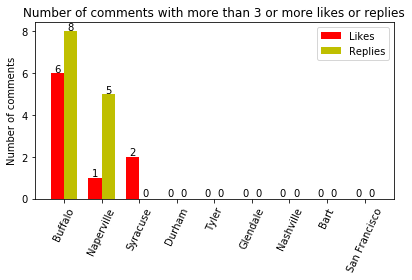

In [276]:
likes_x, likes_y, replies_x, replies_y = transform_likes_replies(likes_x, likes_y, replies_x, replies_y)

N = 9
#men_means = (20, 35, 30, 35, 27)
#men_std = (2, 3, 4, 1, 2)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, likes_y, width, color='r')

#women_means = (25, 32, 34, 20, 25)
#women_std = (3, 5, 2, 3, 3)
rects2 = ax.bar(ind + width, replies_y, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of comments')
ax.set_title('Number of comments with more than 3 or more likes/replies')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(likes_x, rotation=65)

ax.legend((rects1[0], rects2[0]), ('Likes', 'Replies'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.99*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()
fig.savefig('fig-likes-replies.png', dpi = 200)

## authors'a anlysis

In [325]:
authors_names = [('Aaron Couch', 'Software Developer', 'DKAN', 'private'), 
                 ('Aaron Krolikowski', 'Researcher', 'Freelance', 'Academia'), 
                 ('Aaron Lee', 'Software Developer', 'Solace Systems', 'Private'), 
                 ('Adelaide Rosa', 'Unknown', 'Unknown', 'Unknown'), 
                 ('Andrew Nicklin', 'Technology, Data, and Open Government Strategist', 'GovEx', 'Private/Academia'), 
                 ('Aubrey Hlavaty', 'Unknown', 'Unknown', 'Unknown'), 
                 ('Barbara Bouton', 'Unknown', 'Unknown', 'Unknown'),
                 ('Brian Borncamp', 'Civic Technologist', 'Unknown', 'Unknown'),
                 ('Carl V. Lewis', 'Data Journalist', 'CVL Digital', 'Private' ),
                 ('Chris Slocum', 'Unknown', 'Unknown', 'Unknown'),
                 ('Christopher Fagiani', 'Software Developer', 'Oracle', 'Private'),
                 ('Clinton Blackburn', 'Software Developer', 'edX', 'Private'),
                ('Cory McCoy', 'Unknown', 'Unknown', 'Unknown'),
                ('Curtis Robbins', 'Unknown', 'Unknown', 'Unknown'),
                ('Daniel Wulf', 'Unknown', 'Unknown', 'Unknown'),
                ('Darren Cotton', 'Director of Community Development & Planning', 'University of Buffalo', 'Private/Academia'),
                ('David Gonzalez', 'Head of Technology and Co-Founder', 'Vizzuality', 'Private'),
                ('Doug Crescenzi', 'Software Developer', 'Upstate Interactive', 'Private'),
                ('Douglas Clark', 'Unknown', 'Unknown', 'Unknown'),
                ('Douglas Mokry', 'Unknown', 'Unknown', 'Unknown'),
                ('Eric Roche', 'Chief Data Officer', 'City of Kansas City', 'Government'),
                ('Frank Cetera', 'Politian', 'Green Party', 'Public'),
                ('Gary Deardorff', 'Unknown', 'Unknown', 'Unknown'),
                ('James Full', 'Unknown', 'Unknown', 'Unknown'),
                ('Jane Bachmann', 'Sr. Communications Manager', 'DuPont', 'Private'),
                 ('Jason Parker', 'Unknown', 'Unknown', 'Unknown'),
                 ('Jean Moreno', 'Unknown', 'Unknown', 'Unknown'),
                 ('Jeff McAffee', 'Unknown', 'Unknown', 'Unknown'),
                 ('Jennifer Thompson', 'Statistician', 'RLadies', 'Non-Profit'),
                 ('Jesse Griffis', 'Software Developer', 'NBT Solutions', 'Private'),
                 ('Jesse Lecy', 'Assistant Professor', 'Syracuse University', 'Private/Academia'),
                 ('Jim Harvey', 'Partner', 'Technology and Privacy Group', 'Private/Cybersecurity'),
                 ('Jonathan Levy', 'Open Data Program Manager', 'Chicago Department of Innovation & Technology', 'Government'),
                 ('Jorge Díaz', 'Director for Open Participation and Communities', 'Office of President of Mexico', 'Government'),
                 ('Joseph Ghosen', 'Routing Specialist','Buffalo Board of Education', 'Public'),
                 ('Jurnell Cockhren', 'Software Developer', 'Sophicware', 'Private'),
                 ('K M', 'Unknown', 'Unknown', 'Unknown'),
                 ('Karyn Tareen', 'President & CEO', 'Geocove', 'Private'),
                 ('Kelly Dodd', 'Unknown', 'Unknown', 'Unknown'),
                 ('Kevin Wilson', 'Data Sceintist', 'The University of Chicago', 'Private/Academia'),
                 ('Kirk McLean', 'Special Assistant to the Deputy Mayor', 'City of Buffalo', 'Government'),
                 ('Leonard Escudero', 'Unknown', 'Unknown', 'Unknown'),
                 ('Leslie Sheeler', 'Unknown', 'Unknown', 'Unknown'),
                 ('Lynn Harding', 'Unknown', 'Unknown', 'Unknown'),
                 ('Mark Headd', 'Innovation Specialist', '18F', 'Government'),
                 ('Mary Jo Burgess', 'Unknown', 'Unknown', 'Unknown'),
                 ('Meag Doherty', 'Operations Manager', 'OpenGov Foundation', 'Not-for-profit'),
                 ('Monica Stephens', 'Assistant Professor', 'University of Buffalo', 'Private/Academia'),
                 ('Nicholas Josefowitz', 'Director', 'BART', 'Government'),
                 ('Nitin Vig', 'Civic Technologist', 'McKinsey', 'Private'),
                 ('Paul Crickard', 'Systems Analyst', 'City of Albuquerque', 'Government'),
                 ('Peter Johnson', 'Researcher', 'University of Waterloo', 'Private/Academia'),
                 ('Peter Smith', 'Unknown', 'Unknown', 'Unknown'),
                 ('Ray Strahl', 'Unknown', 'Unknown', 'Unknown'),
                 ('Robert Galbraith', 'Unknown', 'Unknown', 'Unknown'),
                 ('Samantha Linnett', 'Innovation Program Coordinator', 'City of Syracuse', 'Government'),
                 ('Scott Davis', 'Remote Monitoring/Data Analyst', 'Aerotek', 'Private'),
                 ('Sean Myers', 'Co-Founder', 'NBT Solutions', 'Government'),
                 ('Seth Etter', 'Civic Technologist', 'OpenGov Foundation', 'Not-for-profit'),
                 ('Stephanie Perry', 'Unknown', 'Unknown', 'Unknown'),
                 ('Susannah Bartlett', 'Analytics Coordinator', 'City of Syracuse', 'Government'),
                 ('Tom Cappetta', 'Unknown', 'Unknown', 'Unknown'),
                 ('แบงค์ รักนะ', 'Unknown', 'Unknown', 'Unknown'),
                 ("John O'B", 'Unknown', 'Unknown', 'Unknown'),
                  ('Seamus Kraft', 'Civic Technologist', 'OpenGov Foundation', 'Not-for-profit')                  
                ]

In [326]:
full_authors_list = []
positions = []
company_names = []
category = []
authors = []

for name in all_cities_dataframe['author']:
    for name_2 in authors_names:
        if name == name_2[0]:
            authors.append(name_2[0])
            positions.append(name_2[1])
            company_names.append(name_2[2])
            category.append(name_2[3])


In [327]:
for i in all_cities_dataframe['author'].tolist():
    if i not in authors:
        print(i)
#print(len(authors))

In [328]:
all_cities_dataframe['Position'] = positions
all_cities_dataframe['Company_name'] = company_names
all_cities_dataframe['Category_work'] = category

In [329]:
all_cities_dataframe

,comment_id,author,Position,Company_name,Category_work,datetime,num_likes,quoted_text,comment_text,comment_text_aux,reply_ids,city_name
1,E4-XFnl1uKc,Aaron Lee,Software Developer,Solace Systems,Private,2017-01-25 04:32:19,2,None,I am in support of the proposed policy to furt...,<p>I am in support of the proposed policy to f...,[],Buffalo
2,E4-XFnjG3Ac,Aaron Lee,Software Developer,Solace Systems,Private,2017-01-25 04:25:20,0,public participation by providing regular oppo...,I would be interested to see this more finely ...,<p>I would be interested to see this more fine...,[],Buffalo
3,E4-XFnQhy2g,Aaron Krolikowski,Researcher,Freelance,Academia,2017-01-24 22:56:17,3,None,"I strongly support the proposed policy, with a...","<p>I strongly support the proposed policy, wit...",[],Buffalo
4,E4-XFnNQNY8,Aaron Krolikowski,Researcher,Freelance,Academia,2017-01-24 22:46:57,0,"Publish high quality, updated data with docume...",Can the portal include an option for community...,<p>Can the portal include an option for commun...,[],Buffalo
5,E4-XFnJHPCA,Aaron Krolikowski,Researcher,Freelance,Academia,2017-01-24 22:45:58,0,limitations on the disclosure of public inform...,It may be a helpful option to include a reposi...,<p>It may be a helpful option to include a rep...,[],Buffalo
6,E4-XFnFvMJc,Aaron Krolikowski,Researcher,Freelance,Academia,2017-01-24 22:41:07,1,Open Data Governance Committee,Minutes from any and all meetings of this comm...,<p>Minutes from any and all meetings of this c...,[],Buffalo
7,E4-XFnArgxc,Aaron Krolikowski,Researcher,Freelance,Academia,2017-01-24 22:39:41,1,and will include input from the public.,A Citizens Advisory Committee can be designate...,<p>A Citizens Advisory Committee can be design...,[],Buffalo
8,E4-XFm_mHqw,Aaron Krolikowski,Researcher,Freelance,Academia,2017-01-24 22:35:13,0,opportunity,equitable access to opportunity (open data can...,<p>equitable access to opportunity (open data ...,[],Buffalo
9,E4-XFmpVM3o,Aaron Krolikowski,Researcher,Freelance,Academia,2017-01-24 22:34:25,0,how the data is being used,This part of the reporting should make specifi...,<p>This part of the reporting should make spec...,[],Buffalo
10,E4-XFmn4N9w,Aaron Krolikowski,Researcher,Freelance,Academia,2017-01-24 22:31:40,0,Encourage innovative uses of the City's publis...,The open data system should include a space fo...,<p>The open data system should include a space...,[E4-XFncwFNE],Buffalo


In [330]:
 cols = all_cities_dataframe.columns.tolist()

In [331]:
cols

['comment_id',
 'author',
 'Position',
 'Company_name',
 'Category_work',
 'datetime',
 'num_likes',
 'quoted_text',
 'comment_text',
 'comment_text_aux',
 'reply_ids',
 'city_name']

In [567]:
all_cities_dataframe = all_cities_dataframe[['comment_id', 'author', 'Position', 'Company_name', 'Category_work', 'datetime', 'num_likes', 'quoted_text', 'comment_text', 'comment_text_aux', 'reply_ids', 'city_name']]

In [568]:
count_authors = all_cities_dataframe.groupby(['author', 'Position', 'Company_name', 'Category_work', 'city_name']).size().reset_index().rename(columns={0:'count'})

In [573]:
# analysis of authors
count_authors = count_authors.sort_values('count', ascending=False)

In [575]:
count_authors_1 = count_authors.groupby('city_name').head(2)
count_authors_1

,author,Position,Company_name,Category_work,city_name,count
64,Tom Cappetta,Unknown,Unknown,Unknown,Syracuse,18
41,Kevin Wilson,Data Sceintist,The University of Chicago,Private/Academia,Syracuse,12
4,Andrew Nicklin,"Technology, Data, and Open Government Strategist",GovEx,Private/Academia,Buffalo,11
9,Chris Slocum,Unknown,Unknown,Unknown,Buffalo,11
59,Seamus Kraft,Civic Technologist,OpenGov Foundation,Not-for-profit,Naperville,8
20,Eric Roche,Chief Data Officer,City of Kansas City,Government,Naperville,5
37,Jurnell Cockhren,Software Developer,Sophicware,Private,Nashville,3
18,Douglas Clark,Unknown,Unknown,Unknown,Tyler,2
28,Jennifer Thompson,Statistician,RLadies,Non-Profit,Nashville,2
45,Lynn Harding,Unknown,Unknown,Unknown,Glendale,1


### analysis

- Tom Cappetta (Syracuse) and Kevin Wilson (Data Scientist - Syracuse) have commented the most, 18 and 12, respectively.
- Andrew Nicklin, a Technologist, and Chris Slocum have commented the most on City of Buffalo. 
- Seamus Kraft, a Researcher/Academic, commented the most for City of Naperville.

In [407]:
# positions analysis
count_positions = all_cities_dataframe.drop_duplicates('author').reset_index()

In [408]:
count_positions = count_positions.groupby(['Position', 'city_name']).size().reset_index().rename(columns={0:'count'})

In [409]:
count_positions = count_positions.sort_values(['city_name', 'count'], ascending=False).reset_index()

In [410]:
count_positions = count_positions.groupby('city_name').head(2)

In [411]:
count_positions

,index,Position,city_name,count
0,37,Unknown,Tyler,3
1,36,Unknown,Syracuse,5
2,25,Software Developer,Syracuse,2
11,10,Director for Open Participation and Communities,San Francisco,1
12,35,Unknown,San Francisco,1
13,24,Software Developer,Nashville,1
14,28,Statistician,Nashville,1
16,5,Civic Technologist,Naperville,3
17,3,Chief Data Officer,Naperville,1
21,32,Unknown,Glendale,7


### analysis

In [431]:
position_list = count_positions['Position'].tolist()
city_list = count_positions['city_name'].unique().tolist()

In [449]:
import matplotlib
matplotlib.style.use('ggplot')

In [553]:
ax = count_positions.pivot("city_name", "Position", "count").plot.barh(stacked=True)
fig_2 = ax.get_figure()
ax.set_xlabel('Number of comments')
ax.set_title('Who comments the most?')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig_2.tight_layout()
fig_2.show()
fig_2.savefig('who-comments-the-most.png', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')

/Users/summerfellow/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
